# Part II - Ford GoBike Data Exploration
## by Josh Iden

## Investigation Overview


The Ford GoBike dataset provides key information about the bike sharing service in the San Francisco market for February 2019. The purpose of this analysis is to identify key rider trends and the popularity and characteristics of ridership.

## Dataset Overview

The dataset consisted of 183,412 rows and 16 columns. Features included in this dataset:   

- Duration of ride
- Start Time
- End Time
- Start Station & Location (Latitude & Longitude)
- End Station & Location (Latitude & Longitude)
- User Type (Subscriber or Customer)
- Member Birth Year
- Member Gender

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date

%matplotlib inline
sns.set_style('white')

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# convert start time and end time columns to datetime object
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# converting member_birth_year float values to int
# replace the NaN values with zero
df.member_birth_year.replace(np.nan, float(0), inplace=True)
df.member_birth_year = df.member_birth_year.astype(int)
# replace member_birth_year zero values with None
df.member_birth_year.replace(0, None, inplace=True)

# convert duration_sec column to minutes
df['duration_min'] = round(df.duration_sec / 60).astype(int)

# create a date column in the dataframe based on the start time column
df['date'] = df.start_time.dt.to_period('D')

# create day of week (dow) column
df['dow'] = df['start_time'].dt.day_name()

# create weekday column
weekday = []
days = ['Saturday', 'Sunday']

# create weekday column 
for row in df.dow:
    if row not in days:
        weekday.append('Weekday')
    else:
        weekday.append('Weekend')
        
df['weekday'] = weekday
df['weekday'] = df['weekday'].astype('category')

# create age column
# store current year
current_year = date.today().year

# create age column
df['member_age'] = current_year - df['member_birth_year']
df.loc[df.member_birth_year < 1942, 'member_birth_year'] = None
df['member_age'] = current_year - df['member_birth_year']

# create distance_km column
# haversine function to calculate distance in km between two points
# credit https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# loop through the dataframe creating the distance_km column
for row in df:
    start_lat = df.start_station_latitude
    end_lat = df.end_station_latitude
    start_lon = df.start_station_longitude
    end_lon = df.end_station_longitude
    df['distance_km'] = haversine_np(start_lon, start_lat, end_lon, end_lat)
    
# calculate speed as distance divided by time
df['speed'] = round(df.distance_km / df.duration_min, 2)

In [4]:
# create age groups
df.loc[df['member_age'] < 30, 'age_group'] = '20s'
df.loc[(df['member_age'] < 40) & (df['member_age'] >= 30), 'age_group'] = '30s'
df.loc[(df['member_age'] < 50) & (df['member_age'] >= 40), 'age_group'] = '40s'
df.loc[(df['member_age'] < 60) & (df['member_age'] >= 50), 'age_group'] = '50s'
df.loc[(df['member_age'] < 70) & (df['member_age'] >= 60), 'age_group'] = '60s'
df.loc[(df['member_age'] < 80) & (df['member_age'] >= 70), 'age_group'] = '70s'

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of Rides By Day

Over the month of February 2019, weekdays are significantly more popular than the weekends - the only exception being February 13, which upon investigation, turned out to have rained all day! (source: [timeanddate.com](https://www.timeanddate.com/weather/usa/san-francisco/historic?month=2&year=2019))

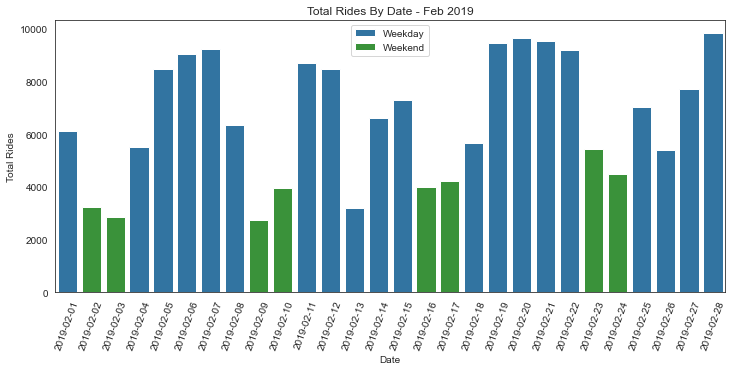

In [5]:
# plot the ride dates
order = df.date.value_counts().index.sort_values()
base_color = sns.color_palette()[0]
plt.figure(figsize=[12,5])
sns.countplot(data=df, x='date', color=base_color, order=order, hue='weekday', palette=['C0', 'C2'], dodge=False)
plt.xlabel('Date')
plt.ylabel('Total Rides')
plt.title('Total Rides By Date - Feb 2019')
plt.xticks(rotation=70)
plt.legend(loc='upper center');

## Average Speed By Age Group

Riders in their 30s and 40s tend to ride fastest, followed by riders in their 20s and 50s.


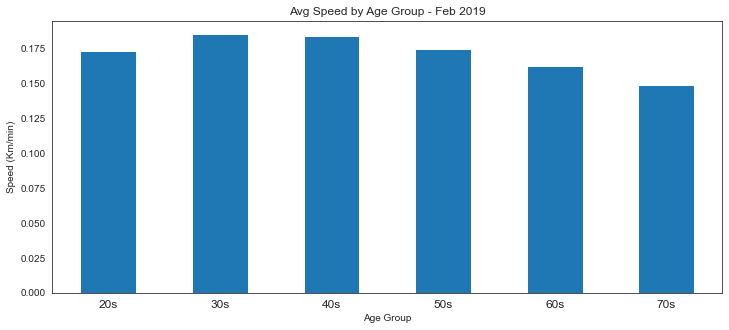

In [6]:
plt.figure(figsize=[12,5])
df.groupby('age_group')['speed'].mean().plot(kind='bar')
plt.xlabel('Age Group')
plt.ylabel('Speed (Km/min)')
plt.xticks(rotation=0, fontsize=12)
plt.title('Avg Speed by Age Group - Feb 2019');

## Average Age of Riders During the Week and Weekend

The average rider is older during the weekdays than on weekends, with a weekday mean/median age 35/37, as opposed to a weekend mean/median age of 33/36.

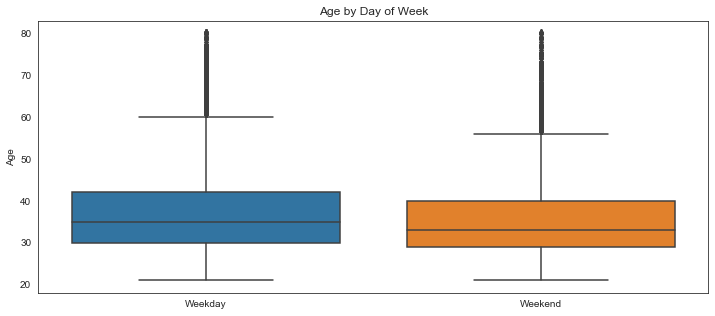

In [7]:
plt.figure(figsize=[12,5])
sns.boxplot(data=df, x='weekday', y='member_age')
plt.xlabel('')
plt.ylabel('Age')
plt.title('Age by Day of Week');

## Summary of Key Insights

Ridership is nearly twice as high on weekdays than on weekends
Riders in their 30s and 40s tend to ride fastest on average
Riders on average are older during weekdays than on weekends, supporting the conclusion that ridership is largely based on workers commuting to work or other weekday commitments than for pleasure.

In [1]:
!jupyter nbconvert Part_II_Explanatory.ipynb --to slides --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_Explanatory.ipynb to slides
[NbConvertApp] Writing 339135 bytes to Part_II_Explanatory.slides.html
